In [1]:
import os

import numpy as np
import tensorflow as tf
from tensorflow import optimizers, losses
from tensorflow.keras import Input, layers, Model

from jarvis.train import datasets, params, custom
from jarvis.train.client import Client
from jarvis.utils.general import overload #, gpus
from jarvis.utils.display import imshow

In [5]:
model = tf.keras.models.load_model('ct_pna.h5')
print(model.summary())
paths = datasets.download(name='ct/pna')
path = '{}/data/ymls/client.yml'.format(paths['code'])
configs = {'batch': {'size': 1, 'fold': 0}}
client = Client(path, configs=configs)
gen_train, gen_valid = client.create_generators()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dat (InputLayer)                [(None, None, 256, 2 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, None, 128, 12 576         dat[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, 128, 12 256         conv3d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, None, 128, 12 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
xs, ys = next(gen_valid)

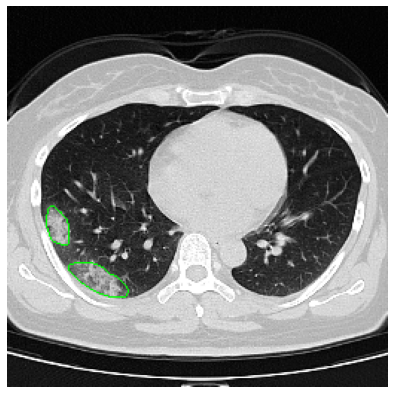

In [21]:
imshow(xs['dat'][0], ys['pna'][0])

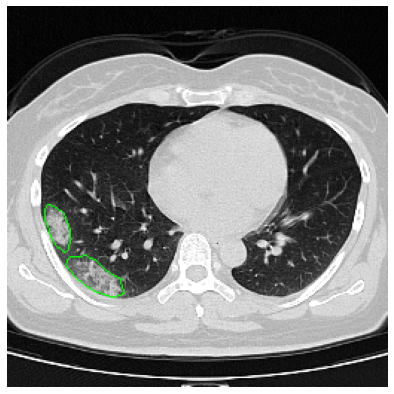

In [22]:
logit = model.predict(xs)
pred = np.argmax(logit, axis=-1)==1
imshow(xs['dat'][0], pred)

In [15]:

def dsc_soft(weights=None, scale=1.0, epsilon=0.01, cls=1):
    @tf.function
    def dsc(y_true, y_pred):
        true = tf.cast(y_true[..., 0] == cls, tf.float32)
        pred = tf.nn.softmax(y_pred, axis=-1)[..., cls]
        if weights is not None:
            true = true * (weights[...])
            pred = pred * (weights[...])
        A = tf.math.reduce_sum(true * pred) * 2
        B = tf.math.reduce_sum(true) + tf.math.reduce_sum(pred) + epsilon
        return (1.0 - A / B) * scale
    return dsc


def sce(weights=None, scale=1.0):
    loss = losses.SparseCategoricalCrossentropy(from_logits=True)
    @tf.function
    def sce(y_true, y_pred):
        return loss(y_true=y_true, y_pred=y_pred, sample_weight=weights) * scale
    return sce


def happy_meal(weights=None, alpha=5, beta=1,  epsilon=0.01, cls=1):
    l2 = sce(None, alpha)
    l1 = dsc_soft(weights, beta, epsilon, cls)
    @tf.function
    def calc_loss(y_true, y_pred):
        return l2(y_true, y_pred) + l1(y_true, y_pred)
    return calc_loss

model = tf.keras.models.load_model('xray_pna.hdf5',custom_objects={'calc_loss':happy_meal(), 'dsc':custom.dsc()} )
print(model.summary())
paths = datasets.download(name='xr/pna-515')
path = '{}/data/ymls/client-seg.yml'.format(paths['code'])
configs = {'batch': {'size': 1, 'fold': 0}}
client = Client(path, configs=configs)
gen_train, gen_valid = client.create_generators()

xs, ys = next(gen_valid)
imshow(xs['dat'][0], ys['pna'][0])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dat (InputLayer)                [(None, 1, 256, 128, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 1, 128, 64, 2 2560        dat[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1, 128, 64, 2 1024        conv3d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1, 128, 64, 2 0           batch_normalization[0][0]        
______________________________________________________________________________________________

KeyError: 'xr/pna-515'

In [12]:
xs, ys = next(gen_valid)

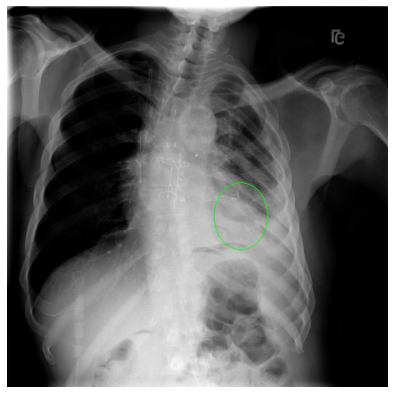

In [16]:
imshow(xs['dat'][0], ys['pna'][0])

In [17]:
logit = model.predict(xs)
pred = np.argmax(logit, axis=-1)==1
imshow(xs['dat'][0], pred)

ValueError: Error when checking input: expected dat to have shape (1, 256, 128, 1) but got array with shape (1, 512, 512, 1)